# Time Series Forecasting - Naive Approach

In [1]:
#%pip install pmdarima
#%pip install sktime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import math
import warnings

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import pmdarima as pmd
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 

file_name = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
time_dependent_variable = "Count"
time_column = "Datetime"
frmt =  "%Y-%m-%d"
Resample_grain = "D"
split= .9          #train and test split

### Reading the csv file

In [3]:
def data(method = "csv"):
    df = pd.read_csv(file_name, parse_dates= True)   
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(Resample_grain).mean()
    df.reset_index(inplace= True)
    return df
df = data()

### Splitting the data into train and test

In [4]:
def train_test_split_perc(df):
    total_size=len(df)
    train_size=math.floor(split*total_size)  #(70% Dataset)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    return train, test


In [5]:
def train_test_split_date(df, split_date):
    split_date = '2017-01-01'
    train = df.loc[df.index <= split_date].copy()
    test = df.loc[df.index > split_date].copy()
    return train, test

### Plot methods

In [6]:
 def plot(method):
    plt.figure(figsize=(12,8))
    plt.plot(train[time_column], train[time_dependent_variable], label='Train')
    plt.plot(test[time_column],test[time_dependent_variable], label='Test')
    plt.plot(y_hat[time_column],y_hat[method], label= method +' forecast')
    plt.legend(loc='best')
    plt.title(method + ' forecast')
    plt.show()
    rms = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    print('RMSE = '+str(rms))


In [7]:
def diagnostic_plot(model_fit, lags= 30):
    fig = plt.figure(figsize=(16, 9))
    fig = model_fit.plot_diagnostics(fig=fig, lags=lags)
    print(model_fit.summary())

### Exogeneous variables using date features (Metadata)

In [8]:
def date_features(df):
    df['year'] = df[time_column].dt.year
    df['quarter'] = df[time_column].dt.quarter
    df['month'] = df[time_column].dt.month
    df['week_day'] = df[time_column].dt.weekday
    return df
df= date_features(df)

In [9]:
df.head()

,Datetime,ID,Count,year,quarter,month,week_day
0,2012-08-25,11.5,3.166667,2012,3,8,5
1,2012-08-26,35.5,3.666667,2012,3,8,6
2,2012-08-27,59.5,2.583333,2012,3,8,0
3,2012-08-28,83.5,2.416667,2012,3,8,1
4,2012-08-29,107.5,2.500000,2012,3,8,2


### Dataframe with Extra Regressors (Metadata)

This function will reorder your columns with time column as first column and time dependent variable column as the last column.
For more information, https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe 

In [10]:
def column_reorder(df):
    df = df[[time_column] + 
        [ col for col in df.columns if col not in [time_column, time_dependent_variable]] + 
        [time_dependent_variable]]
    return df
df = column_reorder(df)
df.head()

,Datetime,ID,year,quarter,month,week_day,Count
0,2012-08-25,11.5,2012,3,8,5,3.166667
1,2012-08-26,35.5,2012,3,8,6,3.666667
2,2012-08-27,59.5,2012,3,8,0,2.583333
3,2012-08-28,83.5,2012,3,8,1,2.416667
4,2012-08-29,107.5,2012,3,8,2,2.500000


### Train and Test split with extra regressors

In [11]:
train, test = train_test_split_perc(df)
y_hat = test.copy()

##### Calling the column_reorder() function before this function is necessary

In [12]:
#  'i' here denotes the starting position of the extra regressors columns 

def extra_regressors_with_iloc(i=1):
    exog_train = train.iloc[:,i:-1]  
    exog_test = test.iloc[:,i:-1]
    return exog_train, exog_test 
exog_train, exog_test = extra_regressors_with_iloc()

In [13]:
exog_train = np.asarray(exog_train, dtype= float)
exog_test = np.asarray(exog_test, dtype= float)
exog = df.iloc[:,1:-1] 

In [14]:
train[time_dependent_variable] = np.asarray(train[time_dependent_variable], dtype= float)
test[time_dependent_variable] = np.asarray(test[time_dependent_variable], dtype= float)

Before starting with the models we can summarize the list of training and test sets :-
- exog_train :- It contains only the exogeneous variables of the training data. (features derived from date and other time dependent variables)
- exog_test  :- It contains only the exogeneous variables of the test data. (features derived from date and other time dependent variables)
- train :- It contains all the variables in the training data.
- test :- It contains all the variables in the test data.
- y_hat :- It is a copy of test data. We will use this table for recording the predictions and evaluating the performance of different models.

# ARX

                            AutoReg Model Results                             
Dep. Variable:                  Count   No. Observations:                  444
Model:             Seas. AutoReg-X(7)   Log Likelihood               -1805.499
Method:               Conditional MLE   S.D. of innovations             15.069
Date:                Sun, 03 Oct 2021   AIC                              5.517
Time:                        17:57:47   BIC                              5.704
Sample:                             7   HQIC                             5.590
                                  444                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.753e+04   4.74e+04     -1.215      0.224    -1.5e+05    3.53e+04
trend      -2.991e+04   2.46e+04     -1.215      0.224   -7.82e+04    1.83e+04
seasonal.1    -1.6684      2.523     -0.661      0.5

30.768829866030607

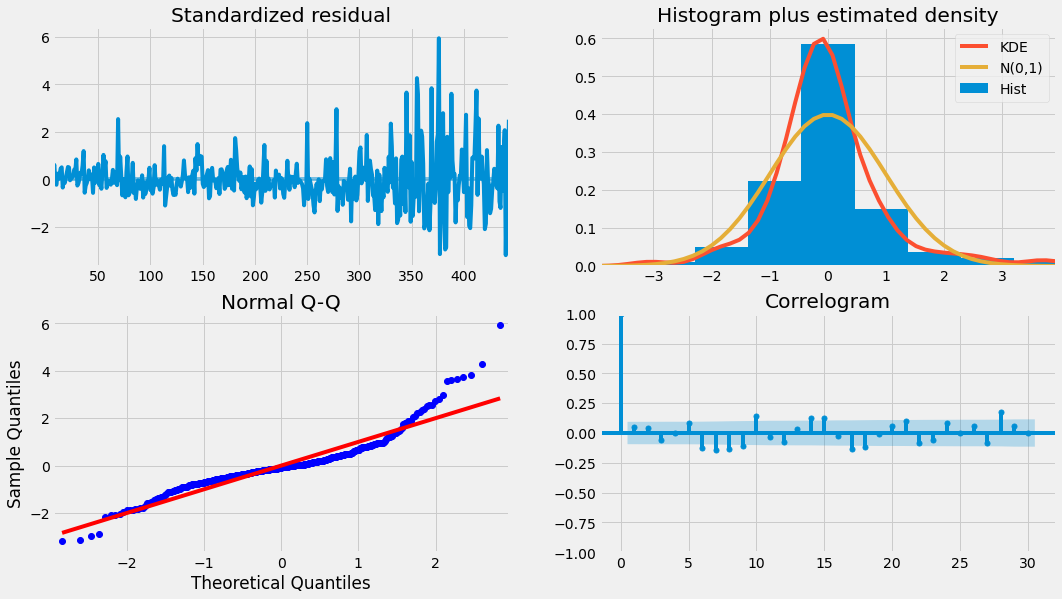

In [16]:
def arx(lags,seasonality_period,method = "ARX"):
    
    model = AutoReg(train[time_dependent_variable],exog=exog_train,lags=lags,trend="ct",seasonal=True,period=seasonality_period)
    fit1 = model.fit()
    
    diagnostic_plot(fit1, lags= 30)
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, exog_oos = exog_test, dynamic=False)
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    return rmse

arx(lags = 7,seasonality_period = 6)

In [17]:
def ar_best_params(p_values=range(40)):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        order = (p,)
        try:
            rmse = ar(*order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
        except:
            continue
    print('Best AR%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = ar_best_params()

Best ARNone RMSE=inf


In [ ]:
ar(*best_cfg)

In [ ]:
y_hat.head()

In [ ]:
plot(method= 'AR' )

# AR with ar_select_order

https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html

This cell sets the plotting style, registers pandas date converters for matplotlib
Also, we set the frequency for the time series to “D” (daily) to avoid warnings when using AutoReg.

In [ ]:
pd.plotting.register_matplotlib_converters()

In [ ]:
def autoreg_select_order(method= "AutoReg"):
    sel = ar_select_order(train[time_dependent_variable],maxlag= 7, exog= exog_train,ic='aic',glob=True,trend='ct',
          seasonal=False, old_names=False)
    res = sel.model.fit()
    diagnostic_plot(res)
    y_hat[method]= res.predict(start=len(train), end=len(train)+len(test)-1, exog= exog_test, dynamic=False)
autoreg_select_order(method= "AutoReg")

In [ ]:
plot(method= "AutoReg")

# AR with pmdarima library

In [ ]:
def auto_ar(max_p = 7, method = "Auto_AR"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=1, 
                          start_q=0,
                          d = 0,
                           max_p = max_p, max_q=0,
                           X= exog_train,
                           trend = trend, seasonal=False,
                           trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test),X= exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
    diagnostic_plot(model)
    

    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    print(rmse)
    
auto_ar()

In [ ]:
plot(method = "Auto_AR")

# MA

In [ ]:
def ma(MA, method = "MA"):
    global y_hat
    model = ARMA(train[time_dependent_variable], order=(0, MA), exog = exog_train)
    
    fit1 = model.fit(disp=False)
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, exog= exog_test, dynamic=False)
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    return rmse
    
ma(MA = 1, method = "MA")



In [ ]:
def ma_best_params(q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:

    for q in q_values:
        order = (q, )
        try:
            rmse = ma(*order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('MA%s RMSE=%.3f' % (order,rmse))
        except:
            continue
    print('Best MA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = ma_best_params()

In [ ]:
ma(*best_cfg)

In [ ]:
plot(method = "MA")

# MA with pmdarima library

In [ ]:
def auto_ma(max_q = 40, method = "Auto_MA"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=0, 
                          start_q=7,
                          d = 0,
                           X= exog_train,
                           max_p = 0, max_q=max_q, seasonal=False,trend = "ct",
                            trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat[method] = model.predict(len(test), X= exog_train)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print("rmse = " + str(sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))))
    
auto_ma()

In [ ]:
plot(method = "Auto_MA")

# ARMA

In [ ]:
def arma(AR,MA, method = "ARMA"):
    global y_hat
    model = ARMA(train[time_dependent_variable], order=(AR,MA))
    
    fit1 = model.fit(disp=False)
    print(fit1.summary())
    
    y_hat[method] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    return rmse
    
arma(AR= 1,MA = 1, method = "ARMA")

In [ ]:
def arma_best_params(p_values=range(7), q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for q in q_values:
            order = (p, q)
            try:
                rmse = arma(*order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
            except:
                continue
    print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
arma_best_params()

In [ ]:
arma(*best_cfg)

In [ ]:
plot(method = "ARMA")

# ARMA with pmdarima

In [ ]:
def auto_arma(max_p = 7, max_q= 7, method = "Auto_ARMA"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=5, 
                          start_q=2,
                           d = 0,
                           max_p = max_p, max_q = max_q,
                           seasonal=False, trend = "ct",
                           trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True)

    
    
    print("\n\n\n\n")
    print(method+" Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test))

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print("rmse = " + str(sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))))
    
auto_arma()

In [ ]:
plot(method = "Auto_ARMA")

# ARIMA

In [ ]:
def arima(p,d,q):

    
    model = ARIMA(train[time_dependent_variable], exog=None, order=(p,d,q))
    fit1 = model.fit()
    
    y_hat['ARIMA'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels')
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat.ARIMA))
    return rmse

arima(1, 1, 1)

In [ ]:
def arima_best_params(p_values=range(7), d_values=range(2), q_values=range(7)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = arima(*order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = arima_best_params()

In [ ]:
arima(*best_cfg)

In [ ]:
plot(method= 'ARIMA' )

# ARIMA With PMDARIMA LIBRARY

• Pmdarima (for py + arima) is a statistical library designed to fill the void in Python’s time-series analysis capabilities, which is the equivalent of R’s auto.arima

In [ ]:
import pmdarima as pmd

def arimamodel():
    autoarima_model = pmd.auto_arima(train[time_dependent_variable], 
                              start_p=1, 
                              start_q=1,
                               max_p=7, max_q=7, 
                              seasonal=False, trend = trend,
                               d=None, trace=True,error_action='ignore',
                              suppress_warnings=True,stepwise=True)
    return autoarima_model


In [ ]:
def auto_arima(max_p= 7, max_q=7, method = "Auto_ARIMA"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                          start_p=1, 
                          start_q=1,
                           max_p=max_p, max_q=max_q,
                           X= exog_train,
                           seasonal=False, 
                           d=None, trace=True,error_action='ignore',
                          suppress_warnings=True,stepwise=True)

    
    
    print("\n\n\n\n")
    print(method + " Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test), X= exog_test)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    

    print("rmse = " + str(sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))))
    
auto_arima()

In [ ]:
plot(method=  "Auto_ARIMA")

# SARIMA

'm' refers to the number of periods in each season. This 'm' has to be decided to be decided using EDA. 

• 7 → Daily

• 12 → Monthly

• 52 → Weekly

• 4 → Quarterly

• 1 → Annual (non-seasonal)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def sarima(p,d,q, P=0,D=0,Q=0,M=7):


    
    model = SARIMAX(train[time_dependent_variable], order=(p,d,q),  seasonal_order=(P,D,Q,M))
    fit1 = model.fit()
    
#   diagnostic_plot(fit1)
    y_hat['SARIMA'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels')
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat.SARIMA))
    return rmse
sarima(1, 1, 1, 1, 1, 3)

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def sarima_best_params(p_values=range(4), d_values=range(2), q_values=range(4), P_values=range(2), D_values=range(4), Q_values=range(2)):
    best_score, best_cfg = float("inf"), None
#for m in [1, 4,7,12,52]:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                order = (p,d,q,P,D,Q)
                                try:
                                    rmse = sarima(*order)
                                    if rmse < best_score:
                                        best_score, best_cfg = rmse, order
                                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                                except:
                                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg 
    
best_cfg = sarima_best_params()

In [ ]:
print(best_cfg)
sarima(*best_cfg)

In [ ]:
plot(method = "SARIMA")

# Seasonal ARIMA using Pmdarima Library

In [ ]:
def auto_sarima(m, max_p= 3, max_q= 3, max_P=3 , max_Q=3  ,method = "Auto_SARIMA"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                               start_p=1, start_q=1,
                                max_p=max_p, max_q=max_q, seasonal=True, start_P=1,
                                start_Q=1, max_P=max_P, max_D=7, max_Q=max_Q, m=m,
                                d=None, D=None, trace=True, error_action='ignore', 
                                suppress_warnings=True,
                                stepwise=True)

    
    
    print("\n\n\n\n")
    print("ARIMA Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test))

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    print("rmse = " + str(rmse))
    return rmse
auto_sarima(m = 7)

In [ ]:
# for m in [1, 4,7,12,52]:
#     print("="*100)
#     print(f' Fitting SARIMA for Seasonal value m = {str(m)}')
#     auto_sarima(method = "Auto_SARIMA")
def auto_sarima_best_seasonal_params():
    best_score, best_cfg = float("inf"), None
    for m in [1, 4,7,12,52]:
        print("="*100)
        print(f' Fitting SARIMA for Seasonal value m = {str(m)}')
        order = m
        try:
            rmse = auto_sarima(m= m)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('SARIMA%s RMSE=%.3f' % (order,rmse))
        except:
            continue
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
best_cfg = auto_sarima_best_seasonal_params()


In [ ]:
auto_sarima(m= best_cfg)

In [ ]:
plot(method=  "Auto_SARIMA")

# Extra Regressors Effect

# ARX

Adding time based features


In [ ]:
def date_features(df):
    

    
    df['month'] = df[time_column].dt.month
    df['year'] = df[time_column].dt.year
    #df['dayofweek'] = df[time_column].dt.strftime('%A')
    df['week_day'] = df[time_column].dt.weekday
    df['quarter'] = df[time_column].dt.quarter
    df['dayofyear'] = df[time_column].dt.dayofyear
    df['dayofmonth'] = df[time_column].dt.day
    df['weekofyear'] = df[time_column].dt.weekofyear
    

    return df
df= date_features(df)

Reordering the columns such that target column (time_depenedent_variable) is set as the last column in the dataset

In [ ]:
def column_reorder(df):
    df = df[[ col for col in df.columns if col != time_dependent_variable] + [time_dependent_variable]]
    return df
df = column_reorder(df)

In [ ]:
train, test = train_test_split_perc(df)
train_X, train_Y = train.iloc[:, 1:-1], train.iloc[:, -1]
test_X, test_Y = test.iloc[:, 1:-1], test.iloc[:, -1]
train_X.head()

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def sarimax(p,d,q, P=0,D=0,Q=0,M=7):


    
    model = SARIMAX(train[time_dependent_variable], exog=train_X, order=(p,d,q),  seasonal_order=(P,D,Q,M))
    fit1 = model.fit()
    print(fit1.summary())
    y_hat['SARIMAX'] = fit1.predict(start=len(train), end=len(train)+len(test)-1,exog= test_X, dynamic=False, typ='levels',start_params=[0, 0, 0, 0, 0, 1])
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat.SARIMAX))
    return rmse
sarimax(1, 1, 1, 1, 1, 3)

In [ ]:
plot(method= 'SARIMAX' )

# SARIMAX with pmdarima Library

In [ ]:
def auto_sarimax(m, max_p= 3, max_q= 3, max_P=3 , max_Q=3  ,method = "Auto_SARIMAX"):
    model = pmd.auto_arima(train[time_dependent_variable], 
                               start_p=1, start_q=1,
                                max_p=max_p, max_q=max_q, exogeneous = train_X, seasonal=True, start_P=1,
                                start_Q=1, max_P=max_P, max_D=7, max_Q=max_Q, m=m,
                                d=None, D=None, trace=True, error_action='ignore', 
                                suppress_warnings=True,
                                stepwise=True)

    
    
    print("\n\n\n\n")
    print(method+ " Model Summary is : ")
    print(model.summary())
    print("\n\n\n\n")
    
    y_hat.loc[:,method] = model.predict(len(test), exogeneous = train_Y)

    print("Test Dataset After Forecast: ")
    print(y_hat.head(5))
    print("\n\n\n\n")
#     arima_model.plot_diagnostics()
    
    rmse = sqrt(mean_squared_error(test[time_dependent_variable], y_hat[method]))
    print("rmse = " + str(rmse))
    return rmse
auto_sarimax(m = 7)

In [ ]:
plot(method = "Auto_SARIMAX")

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [ ]:
def xgboost(method= "Xgboost"):
    
    reg = xgb.XGBRegressor(n_estimators=50)
    reg.fit(train_X, train_Y,
            eval_set=[(train_X, train_Y), (test_X, test_Y )],
            early_stopping_rounds=5,
           verbose=False)
    
    y_hat[method] = reg.predict(test_X)
    _ = plot_importance(reg, height=0.9)
    plot(method= "Xgboost")
xgboost(method= "Xgboost")